In [9]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [11]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [13]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR,MultiStepLR
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime
from sklearn.metrics import confusion_matrix
import scipy.io

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device =  torch.device("cpu")

'''
STEP 3a_v2: CREATE Adaptative spike MODEL CLASS
'''
b_j0 = 0.01  # neural threshold baseline
tau_m = 20  # ms membrane potential constant
R_m = 1  # membrane resistance
dt = 1  #
gamma = .5  # gradient scale
lens = 0.5


# define approximate firing function
class ActFun_adp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):  # input = membrane potential- threshold
        ctx.save_for_backward(input)
        return input.gt(0).float()  # is firing

    @staticmethod
    def backward(ctx, grad_output):  # approximate the gradients
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        #temp = abs(input) < lens
        temp = np.exp((-(input) ** 2 / (2 * lens * lens))) / (np.sqrt(2 * np.pi) * lens)
        return gamma * grad_input * temp.float()


act_fun_adp = ActFun_adp.apply
# membrane potential update

tau_m = torch.FloatTensor([tau_m])


def mem_update_adp(ops, x, mem, spike, tau_adp, b, dt=1, isAdapt=1):
    alpha = torch.exp(-1. * dt / tau_m)
    ro = torch.exp(-1. * dt / tau_adp)
    # tau_adp is tau_adaptative which is learnable # add requiregredients
    if isAdapt:
        beta = 1.8
    else:
        beta = 0.

    b = ro * b + (1 - ro) * spike
    B = b_j0 + beta * b

    mem = mem * alpha + (1 - alpha) * R_m * ops(x) - B * spike * dt
    inputs_ = mem - B
    spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
    return mem, spike, B, b


def mem_update_NU_adp(inputs, mem, spike, tau_adp, b, isAdapt=1, dt=1):
    #     tau_adp = torch.FloatTensor([tau_adp])
    alpha = torch.exp(-1. * dt / tau_m)
    ro = torch.exp(-1. * dt / tau_adp)
    # tau_adp is tau_adaptative which is learnable # add requiregredients
    if isAdapt:
        beta = 1.8
    else:
        beta = 0.

    b = ro * b + (1 - ro) * spike
    B = b_j0 + beta * b

    mem = mem * alpha + (1 - alpha) * R_m * inputs - B * spike * dt
    inputs_ = mem - B
    spike = act_fun_adp(inputs_)  # act_fun : approximation firing function
    return mem, spike, B, b

class RNN_s(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, sub_seq_length,criterion):
        super(RNN_s, self).__init__()
        self.criterion = criterion

        self.hidden_size = hidden_size
        self.output_size = output_size
        self.sub_seq_length = sub_seq_length
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

        self.tau_adp_h = nn.Parameter(torch.Tensor(hidden_size))
        self.tau_adp_o = nn.Parameter(torch.Tensor(output_size))
        nn.init.orthogonal_(self.h2h.weight)
        nn.init.xavier_uniform_(self.i2h.weight)
        nn.init.xavier_uniform_(self.h2o.weight)
        nn.init.constant_(self.i2h.bias, 0)
        nn.init.constant_(self.h2h.bias, 0)
        nn.init.constant_(self.h2o.bias, 0)

        nn.init.constant_(self.tau_adp_h, 7)
        nn.init.constant_(self.tau_adp_o, 100)
        self.b_h = self.b_o = 0

    def forward(self, input,labels):
        self.b_h = self.b_o = 0
        total_spikes = 0
        # Feed in the whole sequence
        batch_size, seq_num, input_dim = input.shape
        # hidden_mem = hidden_spike = torch.zeros(batch_size, self.hidden_size)
        # output_mem = output_spike = out_spike = torch.zeros(batch_size, self.output_size)
        hidden_mem = hidden_spike = torch.rand(batch_size, self.hidden_size)
        output_mem = output_spike = out_spike = torch.rand(batch_size, self.output_size)
        output_spike_sum = torch.zeros(batch_size,seq_num, self.output_size)
        self.b_h = self.b_o = 0.01

        max_iters = 1301
        loss = 0

        output_ = []
        I_h = []
        spike_train = []
        predictions = []
        for i in range(max_iters): # Go through the sequence
            if i < seq_num:
                input_x = input[:, i, :]
            else:
                input_x = torch.zeros(batch_size,input_dim)

            #################   update states  #########################
            h_input = self.i2h(input_x.float()) + self.h2h(hidden_spike)
            hidden_mem, hidden_spike, theta_h, self.b_h = mem_update_NU_adp(h_input,hidden_mem, hidden_spike,
                                                                            self.tau_adp_h, self.b_h,isAdapt=0)#, dt=input_dt_h)

            I_h.append(h_input.data.cpu().numpy())
            spike_train.append(hidden_spike.data.cpu().numpy())
            output_mem, output_spike, theta_o, self.b_o = mem_update_adp(self.h2o, hidden_spike,output_mem,
                                                                         output_spike, self.tau_adp_o, self.b_o)#, dt=input_dt_o)
            output_spike_sum[:,i,:] = output_spike
            total_spikes = total_spikes + int(hidden_spike.sum() + output_spike.sum())
            #################   classification  #########################
            if i >= self.sub_seq_length:
                output_sumspike = output_mem #output_spike_sum[:, i-1:i, :].sum(axis=1)
                output_sumspike = F.log_softmax(output_sumspike,dim=1)

                predictions.append(output_sumspike.data.cpu().numpy())
                output_.append(output_sumspike.data.cpu().numpy())
                loss += self.criterion(output_sumspike, labels[:, i])

        predictions = torch.tensor(predictions)
        return predictions, loss , total_spikes, np.array(spike_train)

    def predict(self,input, lablel):
        prediction = self.forward(input, lablel)
        # prediction, _, total_spikes = self.forward(dt_h, dt_o, max_i, input, lablel)
        return prediction



import scipy.signal as ssg
def convert_seq(x,threshold=0.03):
    l = len(x)
    x= ssg.savgol_filter(x, 5, 3)
    X = np.zeros((l,2))
    for i in range(len(x)-1):
        if x[i+1] - x[i] >= threshold:
            X[i,0] = 1
        elif x[i] - x[i+1] >= threshold:
            X[i,1] = 1
    return X


def expand_dim(x, N):
    y = np.zeros((x.shape[0], x.shape[1], N))
    for i in range(x.shape[0]):
        y[i, :, :] = np.tile(x[i,:], (N,1)).transpose()

    return y

def lbl_to_spike(prediction):
    N = len(prediction)
    detections = np.zeros(N)
    for i in range(1, N):
        if (prediction[i] != prediction[i-1]):
            detections[i] = prediction[i]+1
    return detections


def calculate_stats(prediction, lbl, tol):
    decisions = lbl_to_spike(prediction)
    labs = lbl_to_spike(lbl)

    lbl_indices = np.nonzero(labs)
    lbl_indices = np.array(lbl_indices).flatten()

    dist = np.zeros((len(lbl_indices), 6))
    for i in range(len(lbl_indices)):
        index = lbl_indices[i]
        lab = int(labs[index])
        dec_indices = np.array(np.nonzero((decisions-lab) == 0)).flatten()  #indices where decisions == lab
        if len(dec_indices) == 0:
            dist[i, lab - 1] = 250
            continue
        j = np.argmin(np.abs(dec_indices - index))  # j is closest val in dec_indices to index
        dist[i, lab-1] = abs(dec_indices[j]-index)
        if (dist[i, lab-1] <= tol):
            decisions[dec_indices[j]] = 0 # mark as handled

    mean_error = np.mean(dist, axis=0)
    TP = np.sum(dist <= tol, axis=0)
    FN = np.sum(dist > tol, axis=0)

    FP = np.zeros(6)
    for i in decisions[(decisions > 0)]:
        FP[int(i-1)] += 1

    return mean_error, TP, FN, FP

def accuracy_with_window(pred,target,before_window=10,after_window=10):
    # this function will used to replace the function (x-y)==0
    # to 
    acc = 0
    n = len(pred)

    for i,p in enumerate(pred):
        if i< before_window:
            window_label = target[:i+after_window]
        elif n-i<after_window:
            window_label = target[i-before_window:]
        else:
            window_label = target[i-before_window:i+after_window]
        if p in window_label:
            acc += 1
         
    return acc/n

def calculate_stats_delay(prediction, lbl, tol,torlerance = 3):
    decisions = lbl_to_spike(prediction)
    labs = lbl_to_spike(lbl)

    lbl_indices = np.nonzero(labs)
    lbl_indices = np.array(lbl_indices).flatten()

    dist = np.zeros((len(lbl_indices), 6))
    for i in range(len(lbl_indices)):
        index = lbl_indices[i]
        lab = int(labs[index])
        dec_indices = np.array(np.nonzero((decisions-lab) == 0)).flatten()  #indices where decisions == lab
        if len(dec_indices) == 0:
            dist[i, lab - 1] = 250
            continue
        j = np.argmin(np.abs(dec_indices - index))  # j is closest val in dec_indices to index
        dist[i, lab-1] = abs(dec_indices[j]-index)
        if (dist[i, lab-1] <= tol):
            decisions[dec_indices[j]] = 0 # mark as handled

    mean_error = np.mean(dist, axis=0)
    TP = np.sum(dist <= tol, axis=0)
    FN = np.sum(dist > tol, axis=0)

    FP = np.zeros(6)
    for i in decisions[(decisions > 0)]:
        FP[int(i-1)] += 1

    return mean_error, TP, FN, FP



def convert_dataset_wtime(mat_data):
    X = mat_data["x"]
    Y = mat_data["y"]
    t = mat_data["t"]
    Y = np.argmax(Y[:, :, :], axis=-1)
    d1,d2 =  t.shape

    # dt = np.zeros((size(t[:, 1]), size(t[1, :])))
    dt = np.zeros((d1,d2))
    for trace in range(d1):
        dt[trace, 0] = 1
        dt[trace, 1:] = t[trace, 1:] - t[trace, :-1]

    return dt, X, Y


def load_max_i(mat_data):
    max_i = mat_data["max_i"]
    return np.array(max_i.squeeze(),dtype=np.float16)
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # plt.savefig('cm_SRNN_846.png')
    # plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    

In [15]:
train_mat = scipy.io.loadmat('../QTDB_train.mat')
test_mat = scipy.io.loadmat('../QTDB_test.mat')

# # # old dataset
# xxt = np.load('../dataset/test_y.npy')
# print(xxt.shape)
# xxt = np.load('../dataset1/xxt.npy')
# yyt = np.load('../dataset1/yyt.npy')
# xxv = np.load('../dataset1/xxv.npy')
# yyv = np.load('../dataset1/yyv.npy')

train_dt, train_x, train_y = convert_dataset_wtime(train_mat)
train_max_i = load_max_i(train_mat)

test_dt, test_x, test_y = convert_dataset_wtime(test_mat)
test_max_i = load_max_i(test_mat)

nb_of_sample, seq_dim, input_dim = np.shape(train_x)
print('sequence length: {} , input dimension: {}'.format(seq_dim, input_dim))
print('training dataset distribution: ',train_y.shape)
print('test dataset distribution: ',test_y.shape)

sequence length: 1301 , input dimension: 4
training dataset distribution:  (618, 1301)
test dataset distribution:  (141, 1301)


In [ ]:
np.mean(train_x)

In [6]:
# STEP 2: MAKING DATASET ITERABLE
batch_size = 64
n_iters = 300000
lens = 0.5  # hyper-parameters of approximate function
num_epochs = 0
nb_of_batch = nb_of_sample // batch_size

sub_seq_length = 10
#L = seq_dim - sub_seq_length
hidden_dim = 36
output_dim = 6

train_data = TensorDataset(torch.from_numpy(train_x*1.),torch.from_numpy(train_y))
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_data = TensorDataset(torch.from_numpy(test_x*1.),torch.from_numpy(test_y))
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

criterion = nn.NLLLoss()#nn.CrossEntropyLoss()
model = RNN_s(input_size=input_dim, hidden_size=hidden_dim,
                output_size=output_dim, sub_seq_length=sub_seq_length,criterion=criterion)
model.to(device)


# model.load_state_dict(torch.load('./model_0.853338_36_New.pth'))

RNN_s(
  (criterion): NLLLoss()
  (i2h): Linear(in_features=4, out_features=36, bias=True)
  (h2h): Linear(in_features=36, out_features=36, bias=True)
  (h2o): Linear(in_features=36, out_features=6, bias=True)
)

In [7]:
model.load_state_dict(torch.load('./model_0.853338_36_New.pth'))

<All keys matched successfully>

In [8]:
test_seq_dim = test_x.shape[1]

window_size_front = 5
window_size_beind = 5 
acc = []
predicted_list = []
labels_list = []
fr_list = []
stats = {"err": 0, "TP": 0, "FP": 0, "FN": 0}
for i in range(len(test_x)):
    x_emp = test_x[i:i+1]
    y_emp = test_y[i:i+1]

    images = torch.tensor(x_emp*1.).view((-1, test_seq_dim, input_dim)).requires_grad_().to(device)
    labels = torch.tensor(y_emp).view((-1, test_seq_dim)).long().to(device)

    pred,_,spikesum,_ =  model.forward(images,labels) #model.predict(images,labels)
    # print(pred.shape, pred.dtype)
    # print(pred.numpy().shape )
    a_len = 1301-sub_seq_length
    a_np = pred.data.cpu().numpy().reshape(a_len, 6)
    a_np_pred = np.argmax(a_np, axis=1)
    labels = y_emp[0, sub_seq_length:sub_seq_length+a_len].reshape(a_len)
    # acc_ = (a_np_pred == labels).sum() / int(a_len)
    acc_ = accuracy_with_window(a_np_pred.flatten(),labels.flatten(),before_window=window_size_front ,after_window=window_size_beind)
    acc.append(acc_)
    labels_list.extend(labels)
    predicted_list.extend(a_np_pred)
    fr_list.append(spikesum)
    if i%10 == 0:
        print(i,np.mean(acc))

    err, TP, FN, FP = calculate_stats(a_np_pred[30:-30], labels[30:-30], 0.150 * 250)
    stats["err"] = stats["err"] + err / len(test_x)
    stats["TP"] = stats["TP"] + TP
    stats["FP"] = stats["FP"] + FP
    stats["FN"] = stats["FN"] + FN
    
print(stats.items())
print('fr:',np.mean(fr_list)/1301./42.)
test_acc = np.mean(acc)
print('test accuracy: ',np.mean(acc))

0 0.9465530596436871
10 0.9385254559538061
20 0.9238316550477668
30 0.9258889083231304
40 0.9186676994577846
50 0.912060873923543
60 0.9113662048735889
70 0.918765887345763
80 0.9184955676047852
90 0.9190933001932228
100 0.9188747689641156
110 0.9175930384295993
120 0.9202360909282956
130 0.9202287119872755
140 0.9175689855024695
dict_items([('err', array([3.76748186, 1.01513057, 1.04319487, 0.9086288 , 0.97002002,
       1.73929765])), ('TP', array([4253, 4299, 4297, 4294, 4299, 4280])), ('FP', array([738.,  93.,  27.,  31., 131., 768.])), ('FN', array([50,  4,  6,  9,  4, 23]))])
fr: 0.2907288732513192
test accuracy:  0.9175689855024695


## Accuracy with time shift

In [10]:
test_seq_dim = test_x.shape[1]
acc = []
predicted_list = []
labels_list = []
fr_list = []
stats = {"err": 0, "TP": 0, "FP": 0, "FN": 0}
t_shift = 0
for i in range(len(test_x)):
    x_emp = test_x[i:i+1]
    y_emp = test_y[i:i+1]

    images = torch.tensor(x_emp*1.).view((-1, test_seq_dim, input_dim)).requires_grad_().to(device)
    labels = torch.tensor(y_emp).view((-1, test_seq_dim)).long().to(device)

    pred,_,spikesum,_ =  model.forward(images,labels) #model.predict(images,labels)
    # print(pred.shape, pred.dtype)
    # print(pred.numpy().shape )
    a_len = 1301-sub_seq_length
    a_np = pred.data.cpu().numpy().reshape(a_len, 6)
    a_np_pred = np.argmax(a_np, axis=1)
    # print(a_np_pred.shape)
    a_np_pred_shift = a_np_pred[:a_len-t_shift]
    labels = y_emp[0, sub_seq_length:sub_seq_length+a_len].reshape(a_len)
    labels_shift = labels[t_shift:]
    acc_ = (a_np_pred_shift == labels_shift).sum() / int(a_len)
    #acc_ = accuracy_with_window(a_np_pred.flatten(),labels.flatten(),before_window=3,after_window=3)
    acc.append(acc_)
    labels_list.extend(labels)
    predicted_list.extend(a_np_pred)
    fr_list.append(spikesum)
    if i%10 == 0:
        print(i,np.mean(acc))

    err, TP, FN, FP = calculate_stats(a_np_pred[30:-30], labels[30:-30], 0.150 * 250)
    stats["err"] = stats["err"] + err / len(test_x)
    stats["TP"] = stats["TP"] + TP
    stats["FP"] = stats["FP"] + FP
    stats["FN"] = stats["FN"] + FN
    
print(stats.items())
print('fr:',np.mean(fr_list)/1301./42.)
test_acc = np.mean(acc)
print('test accuracy: ',np.mean(acc))

0 0.9031758326878389
10 0.8874022956129849
20 0.8765445760023608
30 0.8764898428325129
40 0.8647295535697418
50 0.854999164654243
60 0.8548970806719915
70 0.8600386205692716
80 0.8585745569995507
90 0.8594240770848053
100 0.8596835671173623
110 0.8555139182559786
120 0.8571163362375248
130 0.8578946434801119
140 0.8544588559091584
dict_items([('err', array([4.93194504, 0.76258907, 1.18140922, 1.14728654, 0.92581813,
       1.77659498])), ('TP', array([4245, 4300, 4297, 4295, 4299, 4281])), ('FP', array([758.,  69.,  35.,  30., 120., 796.])), ('FN', array([58,  3,  6,  8,  4, 22]))])
fr: 0.2906338641125303
test accuracy:  0.8544588559091584


[[34954   752    16    71  1576  4430]
 [ 1524  7147   970     0    38   466]
 [   58   643  8656   451     9    23]
 [   94     0   687  7131  1150     3]
 [  703    35    35  1301 52021  1790]
 [ 4777   310   248   141  4192 45629]]
[[8.30064118e-01 8.46179813e-02 1.50772710e-03 7.80648708e-03
  2.67182043e-02 8.46372824e-02]
 [3.61909285e-02 8.04208394e-01 9.14059555e-02 0.00000000e+00
  6.44220663e-04 8.90315431e-03]
 [1.37734505e-03 7.23528750e-02 8.15680362e-01 4.95876855e-02
  1.52578578e-04 4.39426071e-04]
 [2.23224887e-03 0.00000000e+00 6.47380324e-02 7.84057174e-01
  1.94961516e-02 5.73164441e-05]
 [1.66943719e-02 3.93833690e-03 3.29815303e-03 1.43045629e-01
  8.81921134e-01 3.41988116e-02]
 [1.13440988e-01 3.48824125e-02 2.33697701e-02 1.55030236e-02
  7.10677110e-02 8.71764009e-01]]


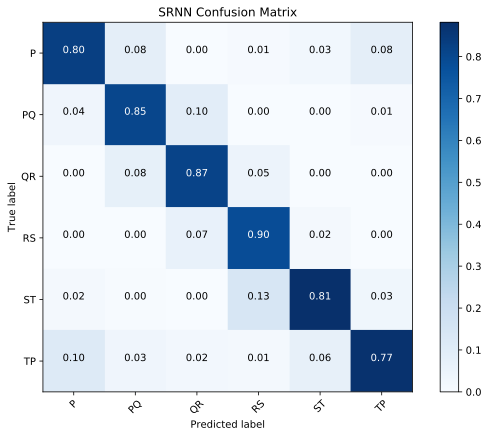

In [12]:
# p_t == y_t+1
predicted_list = np.array(predicted_list).reshape((-1,))
labels_list = np.array(labels_list).reshape(((-1,)))
cm = confusion_matrix(labels_list, predicted_list)
print(cm)
cm_r = cm/cm.sum(axis=0)
print(cm_r)
# import seaborn as sn
plot_confusion_matrix(np.array(cm_r),
                    normalize    = True,
                    target_names = [i for i in ['P','PQ','QR','RS','ST','TP']],
                    title        = "SRNN Confusion Matrix")

## Confusion Matrix

[[34954   752    16    71  1576  4430]
 [ 1524  7147   970     0    38   466]
 [   58   643  8656   451     9    23]
 [   94     0   687  7131  1150     3]
 [  703    35    35  1301 52021  1790]
 [ 4777   310   248   141  4192 45629]]
[[8.30064118e-01 8.46179813e-02 1.50772710e-03 7.80648708e-03
  2.67182043e-02 8.46372824e-02]
 [3.61909285e-02 8.04208394e-01 9.14059555e-02 0.00000000e+00
  6.44220663e-04 8.90315431e-03]
 [1.37734505e-03 7.23528750e-02 8.15680362e-01 4.95876855e-02
  1.52578578e-04 4.39426071e-04]
 [2.23224887e-03 0.00000000e+00 6.47380324e-02 7.84057174e-01
  1.94961516e-02 5.73164441e-05]
 [1.66943719e-02 3.93833690e-03 3.29815303e-03 1.43045629e-01
  8.81921134e-01 3.41988116e-02]
 [1.13440988e-01 3.48824125e-02 2.33697701e-02 1.55030236e-02
  7.10677110e-02 8.71764009e-01]]


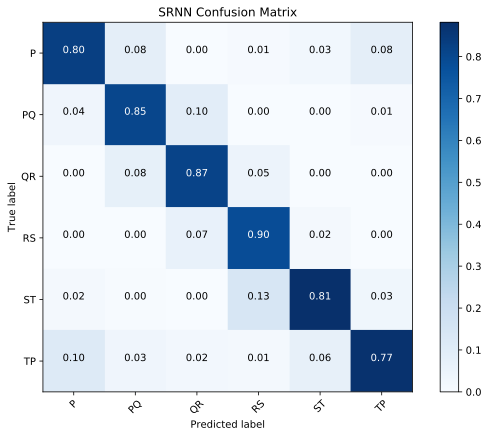

In [14]:
predicted_list = np.array(predicted_list).reshape((-1,))
labels_list = np.array(labels_list).reshape(((-1,)))
cm = confusion_matrix(labels_list, predicted_list)
print(cm)
cm_r = cm/cm.sum(axis=0)
print(cm_r)
# import seaborn as sn
plot_confusion_matrix(np.array(cm_r),
                    normalize    = True,
                    target_names = [i for i in ['P','PQ','QR','RS','ST','TP']],
                    title        = "SRNN Confusion Matrix")
